In [43]:
import statsmodels.api as sm
import scipy.stats as sts
import numpy as np
import pandas as pd
import sympy as sp
import pylab
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings

warnings.filterwarnings("ignore")

Автор: Концевая Наталья Валерьевна

Статья: Модификация адаптивных подходов в моделировании производства электроэнергии в Российской Федерации

Повтор исследования для аналогичных данных США. Необходимо выяснить, будет ли совпадать вывод по работе

# Импорт данных

In [44]:
df = pd.read_excel('USA_electricity_production.xlsx', sheet_name='Sheet1')
df

,Год,Месяц,Y
0,2016.0,июн,101.8
1,NaN,июл,103.2
2,NaN,авг,105.0
3,NaN,сен,100.7
4,NaN,окт,100.7
...,...,...,...
58,NaN,апр,106.1
59,NaN,май,104.3
60,NaN,июн,105.6
61,NaN,июл,97.9


X - временной промежуток с июня 2016 по август 2021

Y - Динамика производства электроэнергии в США в % к соответствующему месяцу предыдущего года

In [45]:
for year in range(1, df.shape[0]):
    if not (df['Год'][year] > 0):
        df['Год'][year] = df['Год'][year-1]

In [46]:
df['Год'] = df['Год'].astype(int)

In [47]:
df['Год, мес'] = df['Год']

In [48]:
for i in range(df.shape[0]):
        df['Год, мес'][i] = str(df['Год'][i])+'.'+df['Месяц'][i]

In [49]:
df.head()

,Год,Месяц,Y,"Год, мес"
0,2016,июн,101.8,2016.июн
1,2016,июл,103.2,2016.июл
2,2016,авг,105.0,2016.авг
3,2016,сен,100.7,2016.сен
4,2016,окт,100.7,2016.окт


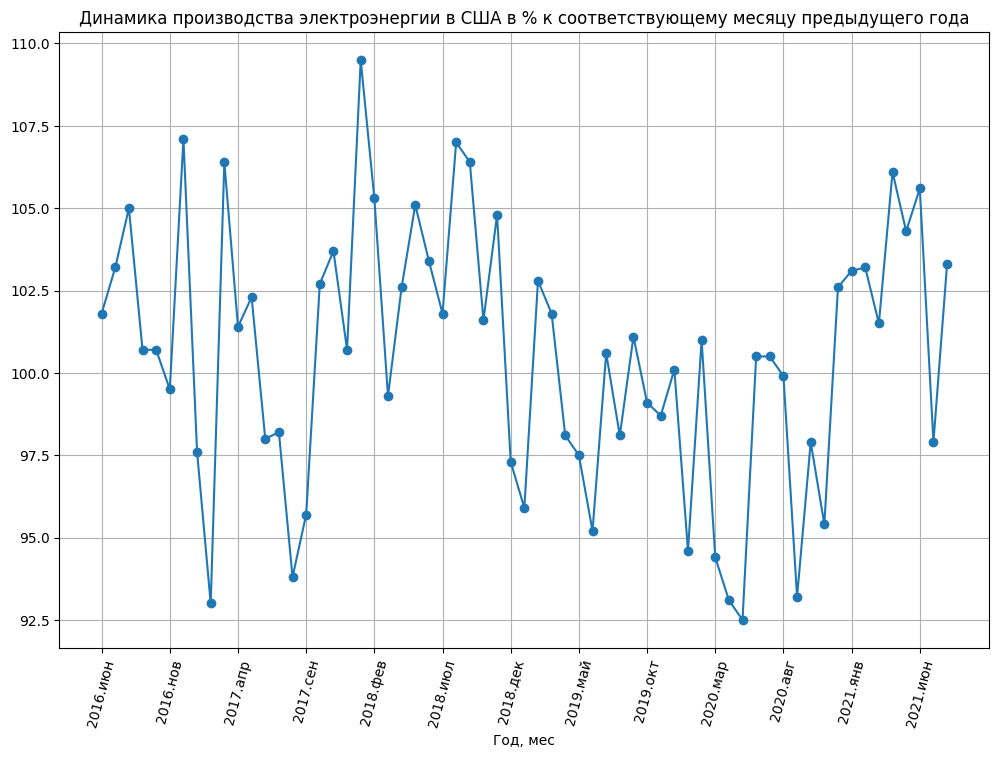

In [50]:
plt.figure(figsize=(12,8))
plt.plot(df["Год, мес"], df["Y"], marker='o', label="Точки")
plt.xlabel("Год, мес")
plt.title("Динамика производства электроэнергии в США в % к соответствующему месяцу предыдущего года")
plt.grid(True)
plt.xticks(df["Год, мес"][::5], rotation=75)
plt.show()

Заметно частично схожее повдение с аналогичной динамикой в РФ

# Идентификация модели временного ряда

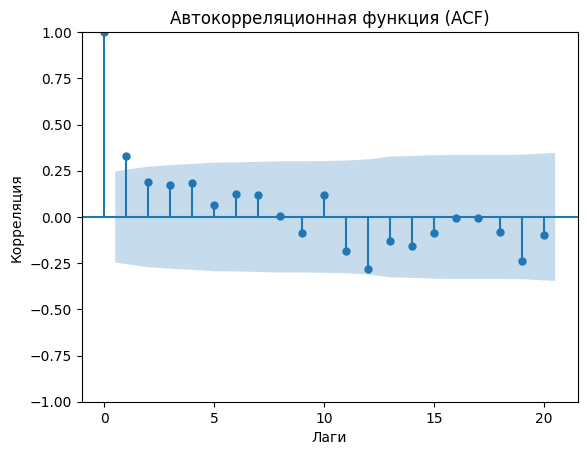

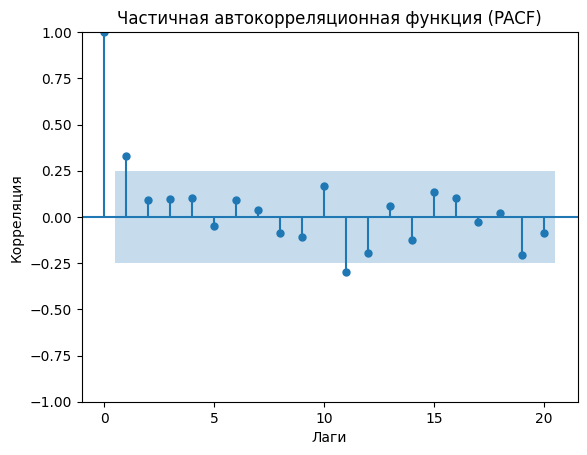

In [60]:
data = df['Y']
plot_acf(data, lags=20)
plt.title('Автокорреляционная функция (ACF)')
plt.xlabel('Лаги')
plt.ylabel('Корреляция')
plt.show()

plot_pacf(data, lags=20)
plt.title('Частичная автокорреляционная функция (PACF)')
plt.xlabel('Лаги')
plt.ylabel('Корреляция')
plt.show()

Для идентификации модели временного ряда, т. е. для определения типа и порядка процесса используют следующие свойства автокорреляционной функции:\
а) Для процесса AR(p) коррелограмма представляет собой смесь экспоненциальной кривой и синусоиды.\
б) Для процесса MA(q) только первые q автокорреляционных коэффициентов значимо отличны от нуля

В соответствии с вышеперечисленными правилами, наилучшей моделью для исследуемого процесса является авторегрессия первого порядка. Такой выбор сделан, поскольку АКФ является экспоненциально убывающей, а в ЧАКФ значимым является только первый коэффициент.

# Потсроение модели

## Для всех данных

In [61]:
df['Y t-1'] = df['Y'].shift()

In [62]:
df.head()

,Год,Месяц,Y,"Год, мес",Y t-1
0,2016,июн,101.8,2016.июн,NaN
1,2016,июл,103.2,2016.июл,101.8
2,2016,авг,105.0,2016.авг,103.2
3,2016,сен,100.7,2016.сен,105.0
4,2016,окт,100.7,2016.окт,100.7


In [63]:
X = df['Y t-1'][1:]
Y = df['Y'][1:]

In [64]:
X_avt = sm.add_constant(X)
model_ar = sm.OLS(Y, X_avt, hasconst = True).fit()
print(model_ar.summary2(title = 'AR(1)'))

                              AR(1)
Model:              OLS              Adj. R-squared:     0.094   
Dependent Variable: Y                AIC:                344.2174
Date:               2024-04-25 23:54 BIC:                348.4717
No. Observations:   62               Log-Likelihood:     -170.11 
Df Model:           1                F-statistic:        7.322   
Df Residuals:       60               Prob (F-statistic): 0.00886 
R-squared:          0.109            Scale:              14.619  
-------------------------------------------------------------------
            Coef.    Std.Err.     t      P>|t|     [0.025    0.975]
-------------------------------------------------------------------
const      67.2878    12.2980   5.4715   0.0000   42.6882   91.8873
Y t-1       0.3308     0.1223   2.7059   0.0089    0.0863    0.5754
-----------------------------------------------------------------
Omnibus:              0.810        Durbin-Watson:           2.045
Prob(Omnibus):        0.667   

Модель в оцененном виде для всего периода наблюдений:

Y_t = 67.2878 + 0.3308 * Y_(t-1) + Et

Проверка на стационарность для AR(1)

|0.3308| < 1 - верно => проверка на стационарность выполнена

DW=2.045 - близко к 2, автокорреляция в остатках отсутствует

F = 7.322, R^2 = 10.9 - Качество модели среднее

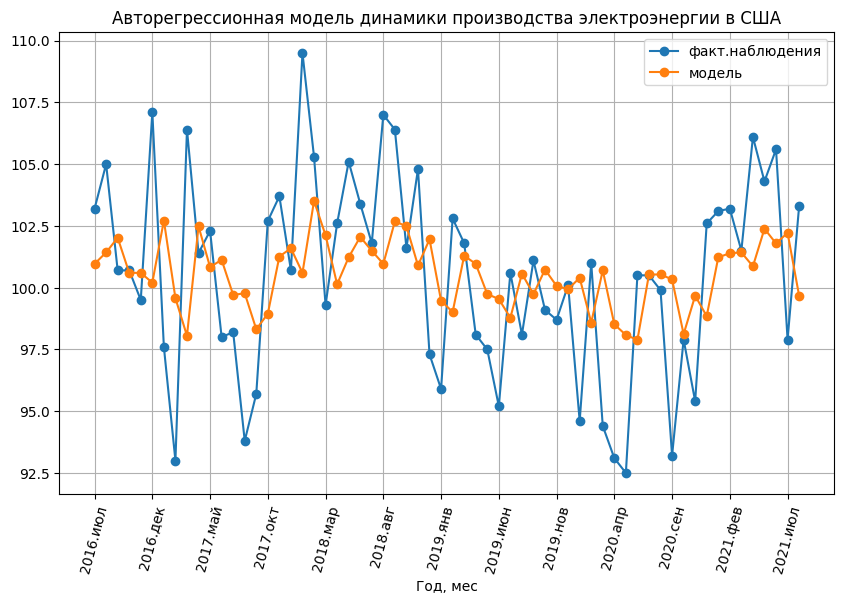

In [69]:
plt.figure(figsize=(10, 6))
plt.plot(df['Год, мес'][1:], Y, label='факт.наблюдения',
marker='o')
plt.plot(df['Год, мес'][1:], model_ar.predict(), label='модель',marker='o')
plt.xlabel("Год, мес")
plt.title("Авторегрессионная модель динамики производства электроэнергии в США")
plt.grid(True)
plt.xticks(df["Год, мес"][1::5], rotation=75)
plt.legend()
plt.show()

Точность модели низкая

## Для последних двух лет

In [70]:
df_part = df.iloc[45:, :]
df_part['T'] = np.arange(1,df_part.shape[0]+1, 1)
df_part.head()

,Год,Месяц,Y,"Год, мес",Y t-1,T
45,2020,мар,94.4,2020.мар,101.0,1
46,2020,апр,93.1,2020.апр,94.4,2
47,2020,май,92.5,2020.май,93.1,3
48,2020,июн,100.5,2020.июн,92.5,4
49,2020,июл,100.5,2020.июл,100.5,5


In [71]:
X_p = df_part.iloc[1:, 4:]
Y_p = df_part['Y'][1:]

X_ar_mod = sm.add_constant(X_p)
model_ar_mod = sm.OLS(Y_p, X_ar_mod, hasconst = True).fit()
print(model_ar_mod.summary2(title = 'AR(1) mod'))

                           AR(1) mod
Model:              OLS              Adj. R-squared:     0.375  
Dependent Variable: Y                AIC:                93.1939
Date:               2024-04-25 23:56 BIC:                95.6936
No. Observations:   17               Log-Likelihood:     -43.597
Df Model:           2                F-statistic:        5.802  
Df Residuals:       14               Prob (F-statistic): 0.0146 
R-squared:          0.453            Scale:              12.005 
------------------------------------------------------------------
          Coef.    Std.Err.     t      P>|t|     [0.025    0.975] 
------------------------------------------------------------------
const    84.9931    25.0703   3.3902   0.0044   31.2226   138.7636
Y t-1     0.0989     0.2679   0.3694   0.7174   -0.4756     0.6735
T         0.5196     0.2386   2.1773   0.0471    0.0078     1.0314
----------------------------------------------------------------
Omnibus:              1.767        Durbin

Модель в оцененном виде:

Y_t = 84.9931 + 0.0989 * Y_(t-1) + 0.5198 * T + Et

DW=1.961 - близко к 2, автокорреляция в остатках отсутствует

F = 5.802, R^2 = 45.3 - Качество модели среднее

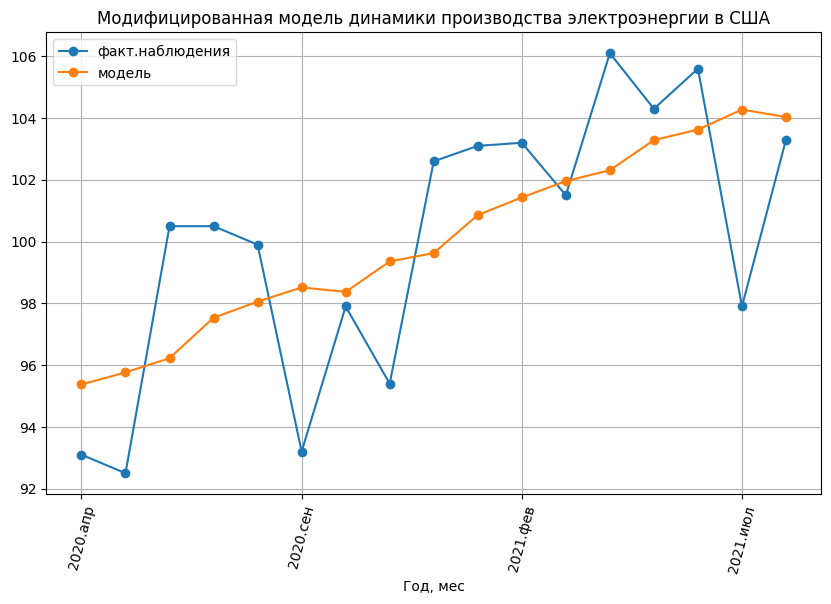

In [72]:
plt.figure(figsize=(10, 6))
plt.plot(df['Год, мес'][46:], Y_p, label='факт.наблюдения',
marker='o')
plt.plot(df['Год, мес'][46:], model_ar_mod.predict(), label='модель',marker='o')
plt.xlabel("Год, мес")
plt.title("Модифицированная модель динамики производства электроэнергии в США")
plt.grid(True)
plt.xticks(df["Год, мес"][46::5], rotation=75)
plt.legend()
plt.show()

Точность модели средняя

# Выводы

В отличии от статьи Н. В. Концевой подход с использованием модификации моделей AR, MA или ARMA дал результат ниже значительно ожиданий.

Построенные модели по данным США имеют низкие прогностические способности, в отличии от исследования по данным РФ. Данный результат во многом связан с другим поведением рынка электроэнергии в США нежели в РФ, а также с более плавным возращением энергетики США в привычное русло после пандемии. Это различие произошло из-за того, что экономика РФ сильнее зависит от цен на нефть, чем экономика США. А в период пандемии цены на нефть имели сильную волатильность, что и привело к очевидным изменениям для рынка электроэнергетики в РФ.